In [339]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [340]:
import pandas as pd
import numpy as np
from mne_bids import (
    BIDSPath,
    find_matching_paths,
    read_raw_bids,
)

In [341]:
data_dir = "../ds004584"
raw_paths: list[BIDSPath] = find_matching_paths(
    data_dir,
    extensions=['.set'],
)
df = pd.read_csv(f"{data_dir}/participants.tsv", sep='\t')

In [342]:
#raw_paths = raw_paths[:20] + raw_paths[120:]
#df = df.drop(df.index[20:120])

In [343]:
assert len(raw_paths) == len(df)
num_raws = len(raw_paths)

In [344]:
raws = [read_raw_bids(path, verbose=False).crop(0, 1) for path in raw_paths]

/tmp/ipykernel_32467/308179560.py:1: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raws = [read_raw_bids(path, verbose=False).crop(0, 1) for path in raw_paths]
/tmp/ipykernel_32467/308179560.py:1: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raws = [read_raw_bids(path, verbose=False).crop(0, 1) for path in raw_paths]
/tmp/ipykernel_32467/308179560.py:1: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "Fp1" will be set to "misc".
  raws = [read_raw_bids(path, verbose=False).crop(0, 1) for path in raw_paths]
/tmp/ipykernel_32467/308179560.py:1: RuntimeWarning: No BIDS -> MNE mapping found for channel type "n/a". Type of channel "Fz" will be set to "misc".
  raws = [read_raw_bid

In [345]:
# Get eeg channel names (some subjects have extra chs)
all_channels = {}
for raw in raws:
    chs = raw.ch_names
    for ch in chs:
        if ch not in all_channels:
            all_channels[ch] = 1
        else:
            all_channels[ch] += 1
drop_channels = []
for (k, v) in all_channels.items():
    if v != num_raws:
        drop_channels.append(k)
print(drop_channels)

['FT9', 'PO3', 'PO4', 'Iz', 'I1', 'I2', 'Resp', 'X', 'Y', 'Z']


In [346]:
for raw in raws:
    raw.drop_channels(drop_channels, on_missing="ignore")

In [347]:
times = []
data = None
for i, raw in enumerate(raws):
    raw_data, time = raw.get_data(return_times=True)
    times.append(time)
    if i == 0:
        data = raw_data
    else:
        print(raw_data.shape)
        data = np.hstack([data, raw_data])
    # data.append(raw_data)
print(times[0].shape)
print(data.shape)
print(len(times))
print(len(data))
n_samples = times[0].shape[0]
n_channels = data.shape[0]


(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)
(60, 501)


In [348]:
#df["times"] = times
#df["data"] = data

In [349]:
df.head()

,participant_id,GROUP,ID,EEG,AGE,GENDER,MOCA,UPDRS,TYPE
0,sub-001,PD,1001,PD1001,80,M,19,28.0,1
1,sub-002,PD,1011,PD1011,81,M,17,25.0,1
2,sub-003,PD,1021,PD1021,68,F,26,10.0,1
3,sub-004,PD,1031,PD1031,80,M,22,10.0,1
4,sub-005,PD,1041,PD1041,56,M,21,13.0,1


In [350]:
from EEGModels import EEGNet
from sklearn.model_selection import train_test_split

In [351]:
model = EEGNet(2, Chans=n_channels,Samples=n_samples)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [352]:
#X = df["data"].to_numpy()
#print(X.shape)
#X = X.reshape(X.shape[0], 60)
#print(X.reshape(X.shape[0], 1))
X = data
y = df["GROUP"]
y = pd.get_dummies(y)
y.head()

,Control,PD
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [361]:

X = X.reshape(num_raws, n_channels,  n_samples, 1)
x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, stratify=y)
print(y_tmp.shape)
print(x_tmp.shape)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, stratify=y_tmp)
x_train.shape
#x_train = x_train.reshape(x_train.shape[0], 62, len(times), 1)

(30, 2)
(30, 60, 501, 1)


(119, 60, 501, 1)

In [363]:
hist = model.fit(X, y, batch_size=16, epochs=300, verbose=2, validation_data=(x_val, y_val))

Epoch 1/300
10/10 - 1s - loss: 0.4835 - accuracy: 0.7852 - val_loss: 0.6373 - val_accuracy: 0.6667 - 873ms/epoch - 87ms/step
Epoch 2/300
10/10 - 1s - loss: 0.4986 - accuracy: 0.7785 - val_loss: 0.6349 - val_accuracy: 0.6667 - 870ms/epoch - 87ms/step
Epoch 3/300
10/10 - 1s - loss: 0.4322 - accuracy: 0.7987 - val_loss: 0.6329 - val_accuracy: 0.6667 - 874ms/epoch - 87ms/step
Epoch 4/300
10/10 - 1s - loss: 0.4786 - accuracy: 0.7919 - val_loss: 0.6368 - val_accuracy: 0.6667 - 842ms/epoch - 84ms/step
Epoch 5/300
10/10 - 1s - loss: 0.4849 - accuracy: 0.7919 - val_loss: 0.6407 - val_accuracy: 0.6667 - 829ms/epoch - 83ms/step
Epoch 6/300
10/10 - 1s - loss: 0.4821 - accuracy: 0.7987 - val_loss: 0.6370 - val_accuracy: 0.6667 - 849ms/epoch - 85ms/step
Epoch 7/300
10/10 - 1s - loss: 0.4864 - accuracy: 0.7852 - val_loss: 0.6340 - val_accuracy: 0.6667 - 879ms/epoch - 88ms/step
Epoch 8/300
10/10 - 1s - loss: 0.4605 - accuracy: 0.8054 - val_loss: 0.6328 - val_accuracy: 0.6667 - 899ms/epoch - 90ms/step


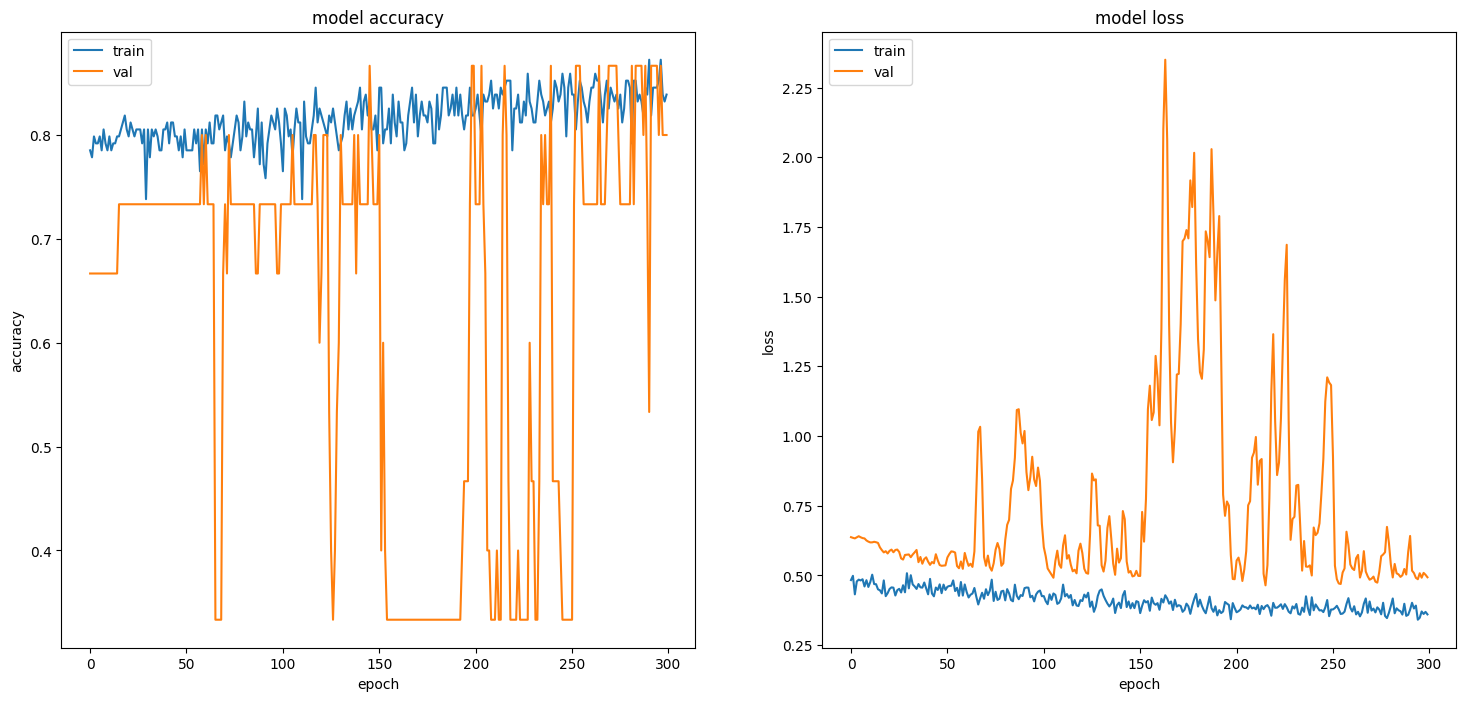

In [365]:
import matplotlib.pyplot as plt

f,ax=plt.subplots(1,2,figsize=(18,8))

ax[0].plot(hist.history['accuracy']) # Type your solution
ax[0].plot(hist.history['val_accuracy']) # Type your solution
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(hist.history['loss']) # Type your solution
ax[1].plot(hist.history['val_loss']) # Type your solution
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

